In [1]:
from matplotlib import pyplot as plt
from matplotlib import pylab #displays arrays as images for easy error checking
import numpy as np
import scipy as sp
import networkx as nx

%matplotlib inline

In [2]:
#Important variables
network_size = 1000 #side length of network boundaries
CNT_length_normal = 1000 #normal length of CNT at center of distribution
CNT_length_stddev = 2 #standard deviation of CNT length from normal
CNT_num_tubes = 1000 #number of tubes in film

CNT_init = np.zeros((CNT_num_tubes+2,6))

#creating the pseudo tubes that will act as the edges in the network
CNT_init[0:2,:] = [[network_size,0,0,0,0,network_size],
                   [network_size,0,1,0,network_size,network_size]]

#Generating tube information
#randomly assigning tube lengths distributed around a set tube length
CNT_init[2:,0] = np.random.normal(CNT_length_normal, CNT_length_stddev, CNT_num_tubes)

#randomly assign starting point and orientation
CNT_init[2:,1:4] = np.random.rand(CNT_num_tubes, 3)

#applying scaling to random numbers so they match the needed values
scaling_factor = np.array([1, network_size, network_size, 2*np.pi, 1, 1])
CNT_init = CNT_init * scaling_factor

#calculating the x-range for the tubes
CNT_init[:,5] = np.cos(CNT_init[:,3]) * CNT_init[:,0]

#calculating slope
CNT_init[:,3] = np.tan(CNT_init[:,3])

#calculating the y-intercept of the lines
CNT_init[:,4] = CNT_init[:,2] - CNT_init[:,3] * CNT_init[:,2]

In [3]:
#generating a boolean array of the tubes that intersect
CNT_intersect = np.zeros((CNT_num_tubes,CNT_num_tubes),dtype=bool)
for i in range(0,CNT_num_tubes):
    m1 = CNT_init[i,3]
    b1 = CNT_init[i,4]
    for j in range(i+1,CNT_num_tubes):
        #checking for parallel tubes
        if m1 == CNT_init[j,3]:
            CNT_intersect[i,j] = False
            continue
        x_intersect = (CNT_init[j,4] - b1) / (m1 - CNT_init[j,3])
        if CNT_init[i,1] <= x_intersect <= CNT_init[i,5] and CNT_init[j,1] <= x_intersect <= CNT_init[j,5]:
            CNT_intersect[i,j] = True

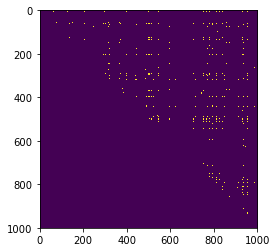

In [4]:
#DELETE THIS CELL IN FINAL CODE THIS CELL IS FOR DEBUGGING
pylab.imshow(CNT_intersect)

In [5]:
#gives the indicies along the x-axis of the true values as the 
#first array and the y-values as the second array
CNT_tube_num1, CNT_tube_num2 = np.where(CNT_intersect)
edges = [None]*np.sum(CNT_intersect)

#formatting the intersection data so it will fit work with networkX
for k in range(0,np.sum(CNT_intersect)):
    edges[k] = (CNT_tube_num1[k], CNT_tube_num2[k], {'resistance': 10.})

In [6]:
graph = nx.Graph()
graph.add_edges_from(edges)

In [7]:
# Functions for equivalent resistance calculation

def G_matrix(graph):
    """
    Using the data from the input networkx graph, returns
    the G matrix needed to complete the nodal analysis calculation.
    """
    # Find the reciprocal of resistance for each connection (i.e. each edge)
    for node1, node2 in graph.edges():
        graph[node1][node2]['reciprocalR'] = 1.0 / graph[node1][node2]['resistance']
    # The adjacency matrix gives all needed elements but the diagonal
    G = nx.adjacency_matrix(graph, weight='reciprocalR')
    # Add the diagonal
    G.setdiag(np.squeeze(np.asarray(-nx.incidence_matrix(graph, 
                                                          weight='reciprocalR').sum(axis=1))))
    # G is a csr_matrix, but we want an array
    return G.toarray()

def equivalent_resistance(graph, check_nodes):
    """
    Given a graph and a list of two check nodes,
    computes the equivalent resistance.
    """

    # Get the G matrix
    G = G_matrix(graph)
    
    # Get the matrix of currents, I
    #I = np.zeros(CNT_num_tubes) - problem with this: we don't want to include tubes with no intersections
    #I = np.zeros(graph.number_of_edges()) - alsp problem but I don't know why
    I = np.zeros(len(G))
    print("Graph has {} edges".format(len(G)))
    I[check_nodes[0]] = 1.
    I[check_nodes[1]] = -1.
  
    #####################################
    ## Remove after debugging finishes ##
    #####################################
    ##print(G)                      #######
    ##print(I)                      #######
    #####################################
    ## Remove after debugging finishes ##
    #####################################
    
    # Solve for the voltage matrix
    try:
        V = np.linalg.solve(G, I)
        
        #####################################
        ## Remove after debugging finishes ##
        #####################################
        ##print(V)                           
        #####################################
        ## Remove after debugging finishes ##
        #####################################
        
        # use a simple numpy operation to compute the equivalent resistance
        equivalent_resistance = abs(sum(I*V))
        return equivalent_resistance
    except:
        # if np.linalg.solve fails, raise an error
        print("Error: could not solve the matrix equation. Is the G-matrix singular?")
        raise

In [8]:
print(nx.has_path(graph, 0, 1))
print(np.shape(G_matrix(graph)))

True
(291, 291)


/Users/mplajer/anaconda/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [9]:

if nx.has_path(graph, 0, 1):
    try:
        print(equivalent_resistance(graph,[0,1]))
    except:
        pass
else:
    print("Could not compute equivalent resistance; there is no contiguous path through the network.")

Graph has 291 edges
Error: could not solve the matrix equation. Is the G-matrix singular?


/Users/mplajer/anaconda/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [10]:
# Right now the challenge is this: it seems that most of the time, this fails due to the G-matrix being singular.